## Generate Molecules using a Reference Molecule and evaluate results (PyTorch)

Intitialising model on mps:0
Generation started...
Generation complete in 29.22


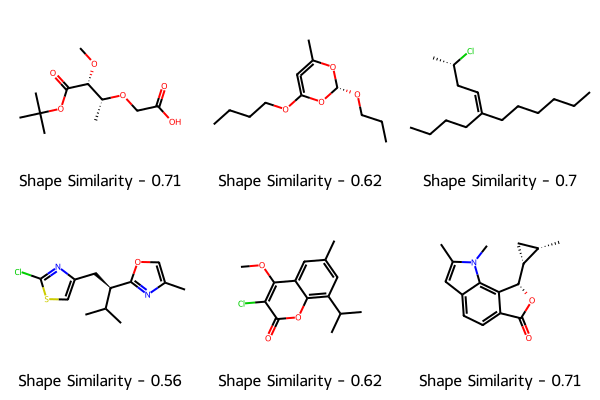

In [15]:
import time
import torch

from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import rdDistGeom
from rdkit.Chem import Draw

from ml_conformer_generator import MLConformerGenerator, evaluate_samples

RDLogger.DisableLog('rdApp.*')

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")

print(f"Intitialising model on {device}")
    
generator = MLConformerGenerator(device=device, diffusion_steps=100)

ref_mol = Chem.MolFromSmiles('Cc1cccc(N2CCC[C@H]2c2ccncn2)n1')
rdDistGeom.EmbedMolecule(ref_mol, forceTol=0.001, randomSeed=12)

# Generate Samples
print("Generation started...")
start = time.time()
samples = generator.generate_conformers(reference_conformer=ref_mol, n_samples=10, variance=2)
print(f"Generation complete in {round(time.time() - start, 2)}")

# Characterise samples   
_, std_samples = evaluate_samples(ref_mol, samples)

# Display results
mols = []
legends = []
for sample in std_samples:
    mol = Chem.MolFromMolBlock(sample['mol_block'])
    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))
    mol.SetProp("Shape_Tanimoto", str(sample['shape_tanimoto']))
    mols.append(mol)
    legends.append(f"Shape Similarity - {round(sample['shape_tanimoto'], 2)}")
    
Draw.MolsToGridImage(mols, legends=legends)

## Generate Molecules using an arbitrary shape (protein pocket) 
requires trimesh >= 4.6.4 library to be installed 

In [7]:
!pip install trimesh

Note: you may need to restart the kernel to use updated packages.


Intitialising model on mps:0
Generation started...
Generation complete in 116.82


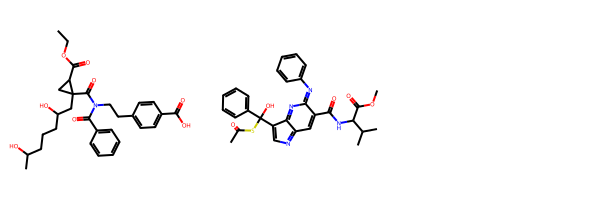

In [16]:
import torch
import trimesh

from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import Draw
from rdkit import RDLogger

from ml_conformer_generator import MLConformerGenerator

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps:0")
else:
    device = torch.device("cpu")

print(f"Intitialising model on {device}")

# Load example - CLK1 pocket as .stl file
mymesh = trimesh.load('./ml_conformer_generator/ml_conformer_generator/utils/mol_examples/6q8k_pocket.stl')
mymesh.density = 0.02

# The shape that you are using needs to be watertight
check = mymesh.is_watertight

if not check:
    raise ValueError("The .stl file needs to be watertight.")

ref_context = torch.tensor(mymesh.principal_inertia_components, dtype=torch.float32)

generator = MLConformerGenerator(device=device)

# Generate Samples
print("Generation started...")
start = time.time()
samples = generator.generate_conformers(reference_context=ref_context, n_atoms=38, n_samples=10, variance=1)
print(f"Generation complete in {round(time.time() - start, 2)}")

# Display results
mols = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in samples]

Draw.MolsToGridImage(mols)

## Export MLConformerGenerator to ONNX

In [11]:
from ml_conformer_generator import MLConformerGenerator
    
generator = MLConformerGenerator()
generator.export_to_onnx()

[torch.onnx] Obtain model graph for `EGNNDynamics([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `EGNNDynamics([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
[torch.onnx] Obtain model graph for `AdjMatSeer([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `AdjMatSeer([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


## Generate Molecules using a Reference Molecule (ONNX)

Generation started...
Generation complete in 63.82


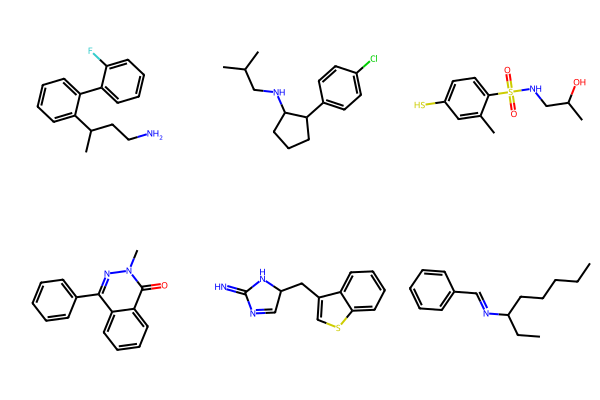

In [18]:
import time

from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit import RDLogger
from rdkit.Chem import Draw

from ml_conformer_generator import MLConformerGeneratorONNX

RDLogger.DisableLog('rdApp.*')
    
generator = MLConformerGeneratorONNX()

ref_mol = Chem.MolFromSmiles('Cc1cccc(N2CCC[C@H]2c2ccncn2)n1')
rdDistGeom.EmbedMolecule(ref_mol, forceTol=0.001, randomSeed=12)

# Generate Samples
print("Generation started...")
start = time.time()
samples = generator.generate_conformers(reference_conformer=ref_mol, n_samples=10, variance=2)
print(f"Generation complete in {round(time.time() - start, 2)}")

# Display results
mols = [Chem.MolFromSmiles(Chem.MolToSmiles(x)) for x in samples]
    
Draw.MolsToGridImage(mols)